### References: 
    1. https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
    
    2. https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047

    3. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

    4. https://fastai1.fast.ai/vision.image.html
    

In [52]:
%matplotlib inline
import matplotlib.gridspec as gridspec
from pycocotools.coco import COCO
from pycocotools import cocoeval, _mask
from pycocotools import mask as maskUtils 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.datasets as dset


import pickle as pkl

from fastai.vision import pil2tensor
from fastai.vision import Image as imgg
import cv2 as cv2
from PIL import Image as Image
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)



## Download dataset

In [5]:
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2020-11-03 01:05:55--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.176.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.176.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.4MB/s    in 2.5s    

2020-11-03 01:05:58 (96.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [6]:
import zipfile
with zipfile.ZipFile('/content/annotations_trainval2017.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Data/annotations')

#### Define path to the training and the annotation data from pre downloaded MS-COCO dataset

In [3]:
# Google colab version comment out when running on jupyter NB
path2data="/content/Data/annotations/train2017"
path2json="/content/Data/annotations/annotations/instances_train2017.json"

### Exploring the dataset

In [4]:
# Initialize the COCO api for instance annotations
coco=COCO(path2json)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get Category names in the MS-COCO Dataset
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

loading annotations into memory...
Done (t=13.21s)
creating index...
index created!


In [5]:
cap = dset.CocoCaptions(root = path2data, 
annFile = path2json,
transform = transforms.ToTensor())
print('Number of samples:', len(cap))


loading annotations into memory...
Done (t=14.37s)
creating index...
index created!
Number of samples: 118287


In [27]:
# Load categories with the specified ids, in this case all
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n {} \n'.format(' '.join(nms)))

COCO categories: 
 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush 



### **Check for Class distribution for plotting histogram of object classes**

In [28]:
i = 0
category = []
categoryCount = []
for cat in nms:
    i=i+1
    catIds = coco.getCatIds(catNms=[cat])
    imgIds = coco.getImgIds(catIds=catIds)
    images = coco.loadImgs(imgIds)
    category.append(cat)
    categoryCount.append(len(imgIds))
    print("imgIds for class {"+str(i)+"}", cat,len(imgIds))

imgIds for class {1} person 64115
imgIds for class {2} bicycle 3252
imgIds for class {3} car 12251
imgIds for class {4} motorcycle 3502
imgIds for class {5} airplane 2986
imgIds for class {6} bus 3952
imgIds for class {7} train 3588
imgIds for class {8} truck 6127
imgIds for class {9} boat 3025
imgIds for class {10} traffic light 4139
imgIds for class {11} fire hydrant 1711
imgIds for class {12} stop sign 1734
imgIds for class {13} parking meter 705
imgIds for class {14} bench 5570
imgIds for class {15} bird 3237
imgIds for class {16} cat 4114
imgIds for class {17} dog 4385
imgIds for class {18} horse 2941
imgIds for class {19} sheep 1529
imgIds for class {20} cow 1968
imgIds for class {21} elephant 2143
imgIds for class {22} bear 960
imgIds for class {23} zebra 1916
imgIds for class {24} giraffe 2546
imgIds for class {25} backpack 5528
imgIds for class {26} umbrella 3968
imgIds for class {27} handbag 6841
imgIds for class {28} tie 3810
imgIds for class {29} suitcase 2402
imgIds for cl

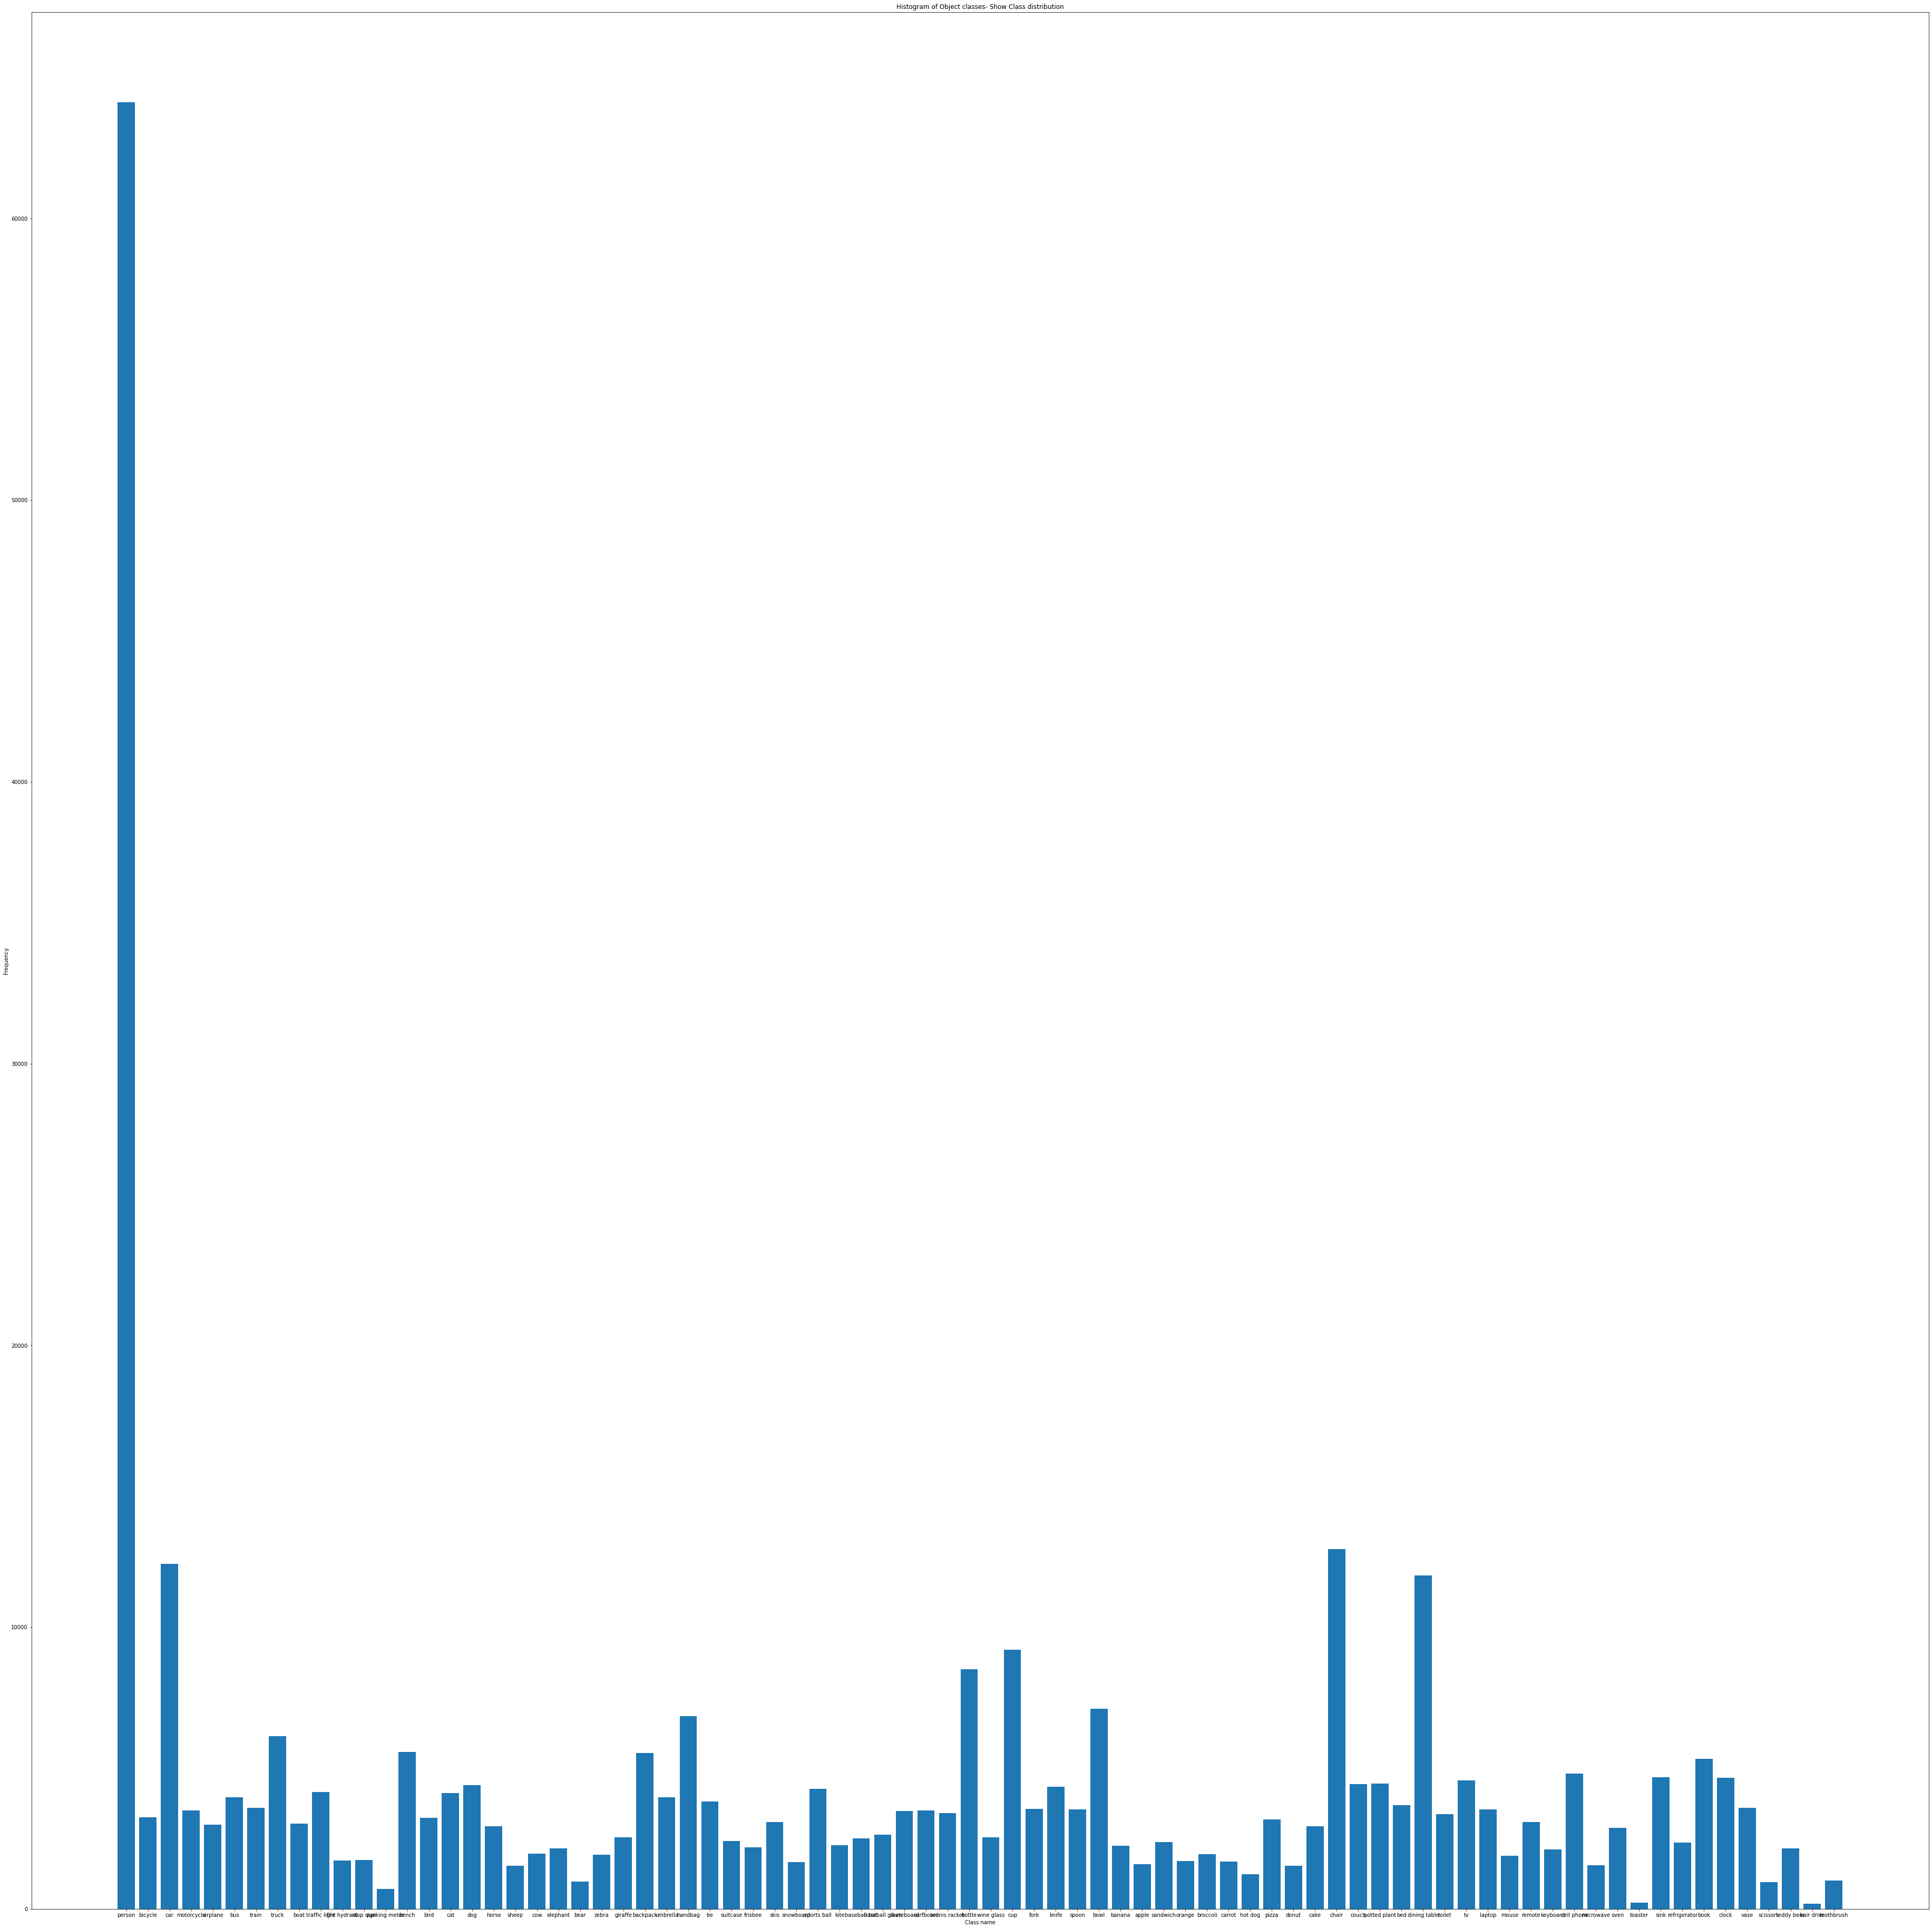

In [29]:
#barplot(prop.table(table(nms)))
fig = plt.figure(figsize=(50,50))
ax = fig.add_axes([0,0,1,1])
ax.bar(category, categoryCount)
plt.title("Histogram of Object classes- Show Class distribution")
plt.xlabel("Class name")
plt.ylabel("Frequency")
plt.show()

## Creating subset of 100 images each of **most often occurring object class** (Person) and **least often occurring object class** (Hair Drier)

In [30]:
import random
## Least occuring class
catIds_1 = coco.getCatIds(catNms=['hair drier'])
imgIds_1 = coco.getImgIds(catIds=catIds_1)
hair_dry_images = coco.loadImgs(imgIds_1)
#print("images of hair drier: ", *hair_dry_images, sep = "\n")

## Creating subset of 100 images in list
#list_hair_drier = hair_dry_images[0:100]
list_hair_drier = random.sample(hair_dry_images, 100)
print ("Least occuring class Hair drier has : " , len(list_hair_drier) , " subset images")

## Most occuring class
catIds_2 = coco.getCatIds(catNms=['person'])
imgIds_2 = coco.getImgIds(catIds=catIds_2)
person_images = coco.loadImgs(imgIds_2)
#print("images of Person: ", *person_images, sep = "\n")

## Creating subset of 100 images in list
#list_person = person_images[0:100]
list_person = random.sample(person_images, 100)
print ("Most occuring class Person has : " , len(list_person) , " subset images")

# merging two subsets of person and hair drier
imgIDSubset = list_person+list_hair_drier

Least occuring class Hair drier has :  100  subset images
Most occuring class Person has :  100  subset images


### Extracting the object from background in the image

In [25]:
def getImage(imageinfo, input_image_size):
    train_img = io.imread(imageinfo['coco_url'])
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

In [24]:
def createBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [23]:
def generateMaskedUnmaskedImages(images, classes, coco,
                      input_image_size=(224,224),batch_size=200, mode='train'):
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size,input_image_size[0], input_image_size[1], 3)).astype('int')
        mask = np.zeros((batch_size,input_image_size[0], input_image_size[1], 1)).astype('int')
        
        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, (224,224))
            
            ### Create Mask ###
            train_mask = createBinaryMask(imageObj, coco, catIds, (224,224))               
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
          c=0
          random.shuffle(images)
            #random.shuffle(images)
        yield img, mask

### Save the set of 100 images each of Person and Hair drier class as .jpg files

In [49]:
def GenerateImages(gen):
    img, mask = next(gen)
    for i in range(len(img)):      
      io.imsave("/content/Data/Generated_Data_Original/Original_Image/{}.jpg".format(str(i)) , img[i])
    for i in range(len(mask)):
      temp = mask[i][:,:,0] * img[i][:,:,2]
      io.imsave("/content/Data/Generated_Data_Masked/Masked_Image/{}.jpg".format(str(i)) , temp)

In [56]:
def visualizeImages(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                temp = mask[j][:,:,0] * img[j][:,:,2]
                ax.imshow(temp)
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

In [ ]:
# Person class is most often occurring object class and hair drier is least often occuring class
classes = ['person', 'hair drier']
val_gen = generateMaskedUnmaskedImages(imgIDSubset, classes, coco, batch_size = len(imgIDSubset))
GenerateImages(val_gen)

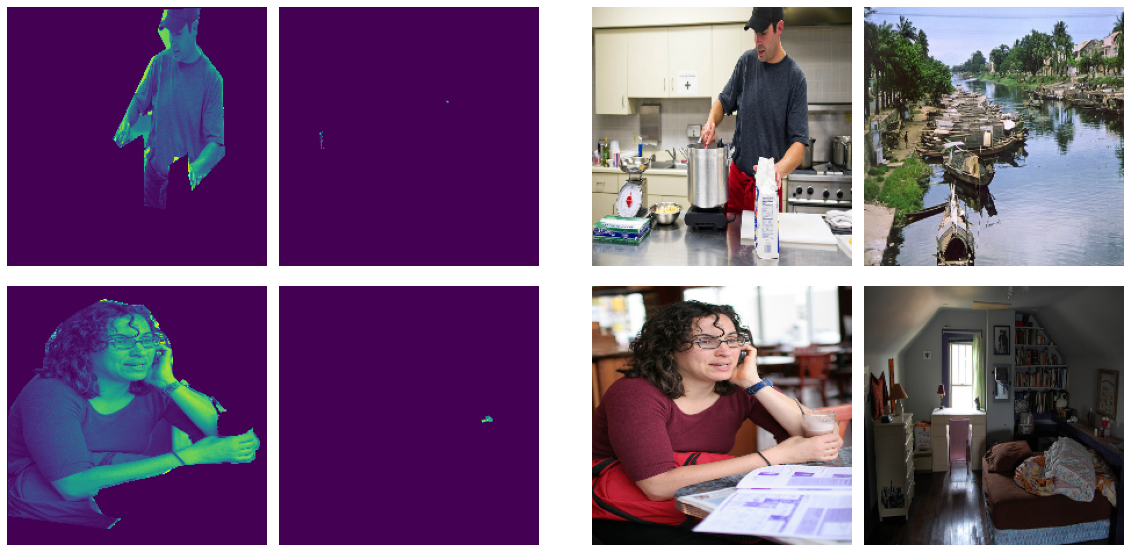

In [59]:
#Sample images original and masked
visualizeImages(val_gen)

# Py-Torch GAN tutorial

## Train GAN on original image dataset containing 200 images of Person and Hair drier

In [60]:
# Root directory for dataset
dataroot = "/content/Data/Generated_Data_Original"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

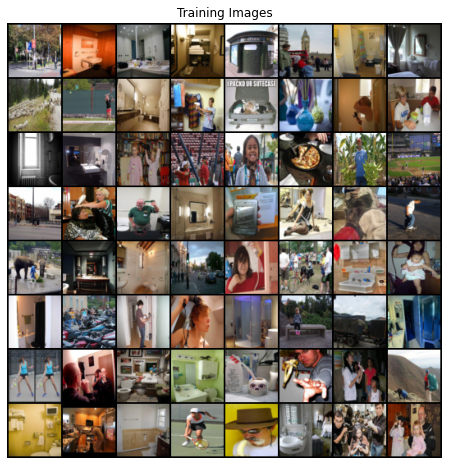

In [61]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_original = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_original))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Weight initialization

In [62]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator code

In [63]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [64]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [38]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss functions

In [39]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training

In [42]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_original, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_original),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_original)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/2]	Loss_D: 0.3942	Loss_G: 9.7117	D(x): 0.9166	D(G(z)): 0.2348 / 0.0001
[1/5][0/2]	Loss_D: 0.6277	Loss_G: 12.7411	D(x): 0.9183	D(G(z)): 0.3722 / 0.0000
[2/5][0/2]	Loss_D: 1.0307	Loss_G: 14.5716	D(x): 0.9425	D(G(z)): 0.5536 / 0.0000
[3/5][0/2]	Loss_D: 0.3183	Loss_G: 9.0105	D(x): 0.8848	D(G(z)): 0.1504 / 0.0002
[4/5][0/2]	Loss_D: 0.6156	Loss_G: 18.1907	D(x): 0.6111	D(G(z)): 0.0000 / 0.0000


Results

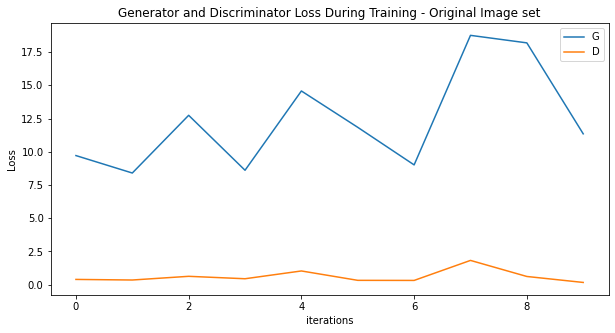

In [43]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training - Original Image set")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train GAN on masked image dataset containing 200 images of Person and Hair drier

In [14]:
# Root directory for dataset
dataroot = "/content/Data/Generated_Data_Masked"

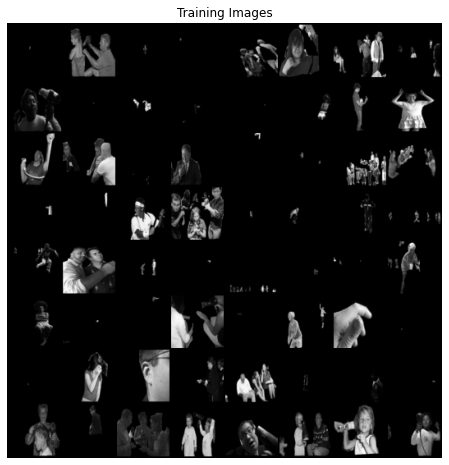

In [15]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_masked = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader_masked))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Weight initialization

Create Generator

In [16]:
# Create the generator
netG_M = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG_M = nn.DataParallel(netG_M, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG_M.apply(weights_init)

# Print the model
print(netG_M)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
# Create the Discriminator
netD_M = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD_M = nn.DataParallel(netD_M, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD_M.apply(weights_init)

# Print the model
print(netD_M)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss functions

In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD_M.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG_M.parameters(), lr=lr, betas=(beta1, 0.999))

Training

In [19]:
# Training Loop

# Lists to keep track of progress
img_list_M = []
G_losses_M = []
D_losses_M = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_masked, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_M.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD_M(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG_M(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD_M(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_M.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_M(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_masked),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses_M.append(errG.item())
        D_losses_M.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_masked)-1)):
            with torch.no_grad():
                fake = netG_M(fixed_noise).detach().cpu()
            img_list_M.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/2]	Loss_D: 1.6282	Loss_G: 3.7109	D(x): 0.4208	D(G(z)): 0.3859 / 0.0356
[1/5][0/2]	Loss_D: 0.5349	Loss_G: 6.9458	D(x): 0.9982	D(G(z)): 0.3716 / 0.0018
[2/5][0/2]	Loss_D: 0.2425	Loss_G: 6.4969	D(x): 0.9783	D(G(z)): 0.1791 / 0.0025
[3/5][0/2]	Loss_D: 0.1488	Loss_G: 7.2945	D(x): 0.9360	D(G(z)): 0.0688 / 0.0012
[4/5][0/2]	Loss_D: 0.2416	Loss_G: 9.0973	D(x): 0.9820	D(G(z)): 0.1834 / 0.0002


Results

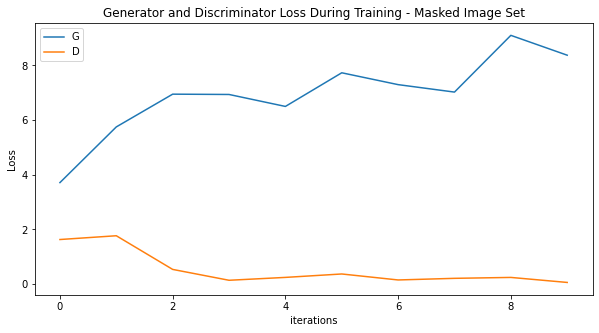

In [65]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training - Masked Image Set")
plt.plot(G_losses_M,label="G")
plt.plot(D_losses_M,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Analysis**

After exploring the MS COCO dataset, we can see that the dataset contains 80 classes of common objects and their context. And an image can be formed by combining several classes. This adds complexity to the image as there is diversity in image (combination of classes), image size, number of objects/categories present in the image.

From the histogram of object classes we observe that, the data is distribute quite uniformly except for the person class, which has the highest number of images annotated as Person.

From the GAN training, we observe that, when we are training the dataset of 200 images without the blackened background ( original images), as the iteration increases, the loss for the generator also increases rapidly. on the contrary for Discriminator model its quite the opposite, as the iterations increases, the training loss also reduces. This means that the discriminator is able to classify real samples efficiently from fake ones.

However, while training the GAN on the black-colored background (masked image), initially the generator and the discriminator have similar losses, and we can also see that when the iteration increases the discriminator also encounters an increase in loss, but then loss reduces rapidly as more iterations occurs, thus signalling that the discriminator is doing a good job.